In [17]:
%load_ext autoreload
%autoreload 2
import numpy as np
import json
import wandb
import dfs_code
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
sys.path = ['../../src'] + sys.path
from dfs_transformer import DFSCodeSeq2SeqFC, TrainerNew, PubChem, get_n_files, TransformerPlusHeads
from dfs_transformer.training.utils import seq_loss, seq_acc, collate_BERT, collate_rnd2min
import argparse
import yaml
import functools
from ml_collections import ConfigDict
from copy import deepcopy
import pickle
from sklearn.metrics import r2_score
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2*2048, rlimit[1]))
#torch.multiprocessing.set_sharing_strategy('file_system')



args = ConfigDict({
    'yaml_model':"../../config/selfattn/model/bert.yaml",
    'yaml_data':"../../config/selfattn/data/pubchem1M.yaml",
    'yaml_training':"../../config/selfattn/training/min2min_new.yaml"
})

config = ConfigDict({'model':{}, 'data':{}, 'training':{}})
with open(args.yaml_model) as file:
    config.model = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))
with open(args.yaml_data) as file:
    config.data = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))
with open(args.yaml_training) as file:
    config.training = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

m = deepcopy(config.model)
t = deepcopy(config.training)
d = deepcopy(config.data)

device = torch.device('cuda:%d'%config.training.gpu_id if torch.cuda.is_available() else 'cpu')

m['no_features'] = False
m['use_loops'] = False

d.molecular_properties = []

config.training.fraction_missing=0 #0.5


if t.mode == "min2min":
    collate_fn = functools.partial(collate_BERT, 
                                   mode="min2min", 
                                   fraction_missing = config.training.fraction_missing,
                                   use_loops=m.use_loops)
elif t.mode == "rnd2rnd":
    collate_fn = functools.partial(collate_BERT, 
                                   mode="rnd2rnd", 
                                   fraction_missing = config.training.fraction_missing,
                                   use_loops=m.use_loops)
elif t.mode == "rnd2min":
    collate_fn = functools.partial(collate_rnd2min,
                                       use_loops=m.use_loops)

validloader = None
if d.valid_path is not None:
    validset = PubChem(d.valid_path, max_nodes=m.max_nodes, max_edges=m.max_edges, noFeatures=m.no_features,
                       molecular_properties=None)
    validloader = DataLoader(validset, batch_size=t.batch_size, shuffle=True, 
                             pin_memory=True, collate_fn=collate_fn)
    exclude = validset.smiles

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9978/9978 [00:01<00:00, 8290.82it/s]


In [18]:
from dfs_transformer import to_cuda as utils_to_cuda
import tqdm
to_cuda = functools.partial(utils_to_cuda, device=device)

In [19]:
loader = validloader

dataset = PubChem(d.path, n_used = d.n_used, max_nodes=m.max_nodes, 
                  max_edges=m.max_edges, exclude=exclude, noFeatures=m.no_features,
                  molecular_properties=d.molecular_properties)
loader = DataLoader(dataset, batch_size=t.batch_size, shuffle=True, 
                    pin_memory=t.pin_memory, collate_fn=collate_fn, num_workers=0,#t.num_workers,
                    prefetch_factor=t.prefetch_factor)

In [20]:
data = next(iter(loader))

In [21]:
batch_id = 1

In [22]:
data[0]['dfs_from'][:, batch_id]

tensor([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
           10,    11,    12,    13,    14,    15,    16,    10,    17,    18,
            5,     0,    20,    21,    22,    23,    24,    25,    26,    26,
           28,    29,    22,    20,    31,    32,    33,    34,    35,    36,
           36,    37, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000])

In [23]:
data[0]['dfs_to'][:, batch_id]

tensor([    1,     2,     3,     4,     5,     6,     7,     8,     9,    10,
           11,    12,    13,    14,    15,    16,    11,    17,    18,     7,
           19,    20,    21,    22,    23,    24,    25,    26,    27,    28,
           29,    23,    30,    31,    32,    33,    34,    35,    36,    31,
           37,     0, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000])

In [24]:
data[0]['atm_from'][:, batch_id]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.0000e+00,  1.2011e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.2011e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.2011e-01],
        ...,
        [-1.0000e+03, -1.0000e+03, -1.0000e+03,  ..., -1.0000e+03,
         -1.0000e+03, -1.0000e+03],
        [-1.0000e+03, -1.0000e+03, -1.0000e+03,  ..., -1.0000e+03,
         -1.0000e+03, -1.0000e+03],
        [-1.0000e+03, -1.0000e+03, -1.0000e+03,  ..., -1.0000e+03,
         -1.0000e+03, -1.0000e+03]])

In [25]:
data[0]['bnd'][:, batch_id]

tensor([[    0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     1.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     0.,     0.,     0.,     1.,     1.,     1.,     1.,     0.,
  

In [26]:
data[0]['atm_to'][:, batch_id][:, :118]

tensor([[    0.,     0.,     0.,  ...,     0.,     0.,     0.],
        [    0.,     0.,     0.,  ...,     0.,     0.,     0.],
        [    0.,     0.,     0.,  ...,     0.,     0.,     0.],
        ...,
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.]])

In [31]:
data

[{'dfs_from': tensor([[    0,     0,     0,  ...,     0,     0,     0],
          [    1,     1,     1,  ...,     1,     1,     1],
          [    2,     2,     2,  ...,     0,     2,     2],
          ...,
          [-1000, -1000, -1000,  ..., -1000, -1000, -1000],
          [-1000, -1000, -1000,  ..., -1000, -1000, -1000],
          [-1000, -1000, -1000,  ..., -1000, -1000, -1000]]),
  'dfs_to': tensor([[    1,     1,     1,  ...,     1,     1,     1],
          [    2,     2,     2,  ...,     2,     2,     2],
          [    3,     3,     3,  ...,     3,     0,     3],
          ...,
          [-1000, -1000, -1000,  ..., -1000, -1000, -1000],
          [-1000, -1000, -1000,  ..., -1000, -1000, -1000],
          [-1000, -1000, -1000,  ..., -1000, -1000, -1000]]),
  'atm_from': tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             1.0000e+00,  1.2011e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  1.2011e

# moleculenet downstream tasks

In [18]:
import deepchem as dc
from dfs_transformer import smiles2graph

dataset = 'clintox'



2022/10/29 18:03:02	INFO	deepchem.molnet.load_function.molnet_loader	About to featurize clintox dataset.
2022/10/29 18:03:03	INFO	deepchem.data.data_loader	Loading raw samples now.
2022/10/29 18:03:03	INFO	deepchem.data.data_loader	shard_size: 8192
2022/10/29 18:03:03	INFO	deepchem.utils.data_utils	About to start loading CSV from /tmp/clintox.csv.gz
2022/10/29 18:03:03	INFO	deepchem.utils.data_utils	Loading shard 1 of size 8192.
2022/10/29 18:03:03	INFO	deepchem.data.data_loader	About to featurize shard.
2022/10/29 18:03:03	INFO	deepchem.feat.base_classes	Featurizing datapoint 0
2022/10/29 18:03:03	WARNING	deepchem.feat.base_classes	Failed to featurize datapoint 7, None. Appending empty array
2022/10/29 18:03:03	WARNING	deepchem.feat.base_classes	Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True

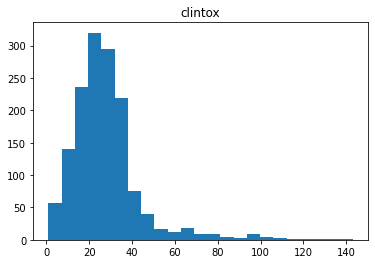

2022/10/29 18:03:08	INFO	deepchem.molnet.load_function.molnet_loader	About to featurize tox21 dataset.
2022/10/29 18:03:09	INFO	deepchem.data.data_loader	Loading raw samples now.
2022/10/29 18:03:09	INFO	deepchem.data.data_loader	shard_size: 8192
2022/10/29 18:03:09	INFO	deepchem.utils.data_utils	About to start loading CSV from /tmp/tox21.csv.gz
2022/10/29 18:03:09	INFO	deepchem.utils.data_utils	Loading shard 1 of size 8192.
2022/10/29 18:03:09	INFO	deepchem.data.data_loader	About to featurize shard.
2022/10/29 18:03:09	INFO	deepchem.feat.base_classes	Featurizing datapoint 0
2022/10/29 18:03:10	INFO	deepchem.feat.base_classes	Featurizing datapoint 1000
2022/10/29 18:03:10	INFO	deepchem.feat.base_classes	Featurizing datapoint 2000
2022/10/29 18:03:10	INFO	deepchem.feat.base_classes	Featurizing datapoint 3000
2022/10/29 18:03:11	INFO	deepchem.feat.base_classes	Featurizing datapoint 4000
2022/10/29 18:03:11	INFO	deepchem.feat.base_classes	Featurizing datapoint 5000
2022/10/29 18:03:12	INF

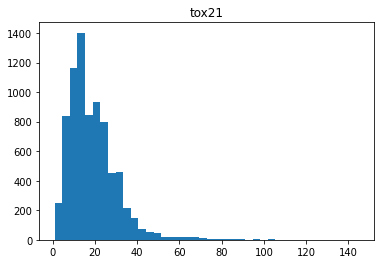

2022/10/29 18:03:28	INFO	deepchem.molnet.load_function.molnet_loader	About to featurize bbbp dataset.
2022/10/29 18:03:29	INFO	deepchem.data.data_loader	Loading raw samples now.
2022/10/29 18:03:29	INFO	deepchem.data.data_loader	shard_size: 8192
2022/10/29 18:03:29	INFO	deepchem.utils.data_utils	About to start loading CSV from /tmp/BBBP.csv
2022/10/29 18:03:29	INFO	deepchem.utils.data_utils	Loading shard 1 of size 8192.
2022/10/29 18:03:29	INFO	deepchem.data.data_loader	About to featurize shard.
2022/10/29 18:03:29	INFO	deepchem.feat.base_classes	Featurizing datapoint 0
2022/10/29 18:03:29	WARNING	deepchem.feat.base_classes	Failed to featurize datapoint 59, None. Appending empty array
2022/10/29 18:03:29	WARNING	deepchem.feat.base_classes	Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
2022/1

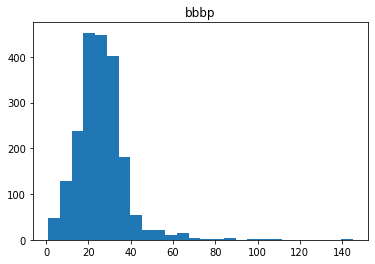

2022/10/29 18:03:35	INFO	deepchem.molnet.load_function.molnet_loader	About to featurize hiv dataset.
2022/10/29 18:03:37	INFO	deepchem.data.data_loader	Loading raw samples now.
2022/10/29 18:03:37	INFO	deepchem.data.data_loader	shard_size: 8192
2022/10/29 18:03:37	INFO	deepchem.utils.data_utils	About to start loading CSV from /tmp/HIV.csv
2022/10/29 18:03:37	INFO	deepchem.utils.data_utils	Loading shard 1 of size 8192.
2022/10/29 18:03:37	INFO	deepchem.data.data_loader	About to featurize shard.
2022/10/29 18:03:37	INFO	deepchem.feat.base_classes	Featurizing datapoint 0
2022/10/29 18:03:37	INFO	deepchem.feat.base_classes	Featurizing datapoint 1000
2022/10/29 18:03:37	INFO	deepchem.feat.base_classes	Featurizing datapoint 2000
2022/10/29 18:03:38	INFO	deepchem.feat.base_classes	Featurizing datapoint 3000
2022/10/29 18:03:38	INFO	deepchem.feat.base_classes	Featurizing datapoint 4000
2022/10/29 18:03:39	INFO	deepchem.feat.base_classes	Featurizing datapoint 5000
2022/10/29 18:03:39	INFO	deepc

In [ ]:
for dataset in ['clintox', 'tox21', 'bbbp', 'hiv']:
    if dataset == 'clintox':
        tasks, datasets, transformers = dc.molnet.load_clintox(reload=False, featurizer=dc.feat.RawFeaturizer(True), splitter=None)
    elif dataset == 'tox21':
        tasks, datasets, transformers = dc.molnet.load_tox21(reload=False, featurizer=dc.feat.RawFeaturizer(True), splitter=None)
    elif dataset == 'hiv':
        tasks, datasets, transformers = dc.molnet.load_hiv(reload=False, featurizer=dc.feat.RawFeaturizer(True), splitter=None)
    elif dataset == 'bbbp':
        tasks, datasets, transformers = dc.molnet.load_bbbp(reload=False, featurizer=dc.feat.RawFeaturizer(True), splitter=None)


    m_vertices = []
    m_edges = []
    for idx, smiles in tqdm.tqdm(enumerate(datasets[0].X)):
        d = smiles2graph(smiles, False, False, np.inf, np.inf)
        m_vertices += [d.atom_features.shape[0]]
        m_edges += [d.edge_index.shape[1]//2]

    plt.hist(m_edges, bins='rice')
    plt.title(dataset)
    plt.show()